In [1]:
import sys
print sys.path

['', '/users/visics/kkelchte/tensorflow/lib/python2.7/site-packages', '/esat/opal/kkelchte/docker_home/tensorflow/tf_cnnvis', '/esat/opal/kkelchte/docker_home/tensorflow/pilot', '/users/visics/kkelchte/tensorflow/lib/python27.zip', '/users/visics/kkelchte/tensorflow/lib64/python2.7', '/users/visics/kkelchte/tensorflow/lib64/python2.7/plat-linux2', '/users/visics/kkelchte/tensorflow/lib64/python2.7/lib-tk', '/users/visics/kkelchte/tensorflow/lib64/python2.7/lib-old', '/users/visics/kkelchte/tensorflow/lib64/python2.7/lib-dynload', '/usr/lib64/python2.7', '/usr/lib/python2.7', '/usr/lib64/python2.7/lib-tk', '/users/visics/kkelchte/tensorflow/lib/python2.7/site-packages/IPython/extensions', '/esat/opal/kkelchte/docker_home/.ipython']


In [4]:
import os, sys, time
import tensorflow as tf
import numpy as np
import argparse

try:
    from pilot.model import Model
    from pilot import data
except ImportError:
    print("failed to load pilot. PYTHONPATH: {}".format(sys.path))

In [5]:
parser = argparse.ArgumentParser(description='Main pilot that can train or evaluate online or offline from a dataset.')

# ==========================
#   Training Parameters
# ==========================
parser.add_argument("--testing", action='store_true', help="In case we're only testing, the model is tested on the test.txt files and not trained.")
parser.add_argument("--learning_rate", default=0.1, type=float, help="Start learning rate.")
parser.add_argument("--batch_size",default=16,type=int,help="Define the size of minibatches.")

# ==========================
#   Offline Parameters
# ==========================
parser.add_argument("--max_episodes",default=600,type=int,help="The maximum number of episodes (~runs through all the training data.)")

# ===========================
#   Utility Parameters
# ===========================
# Print output of ros verbose or not
parser.add_argument("--load_config", action='store_true',help="Load flags from the configuration file found in the checkpoint path.")
parser.add_argument("--verbose", action='store_false', help="Print output of ros verbose or not.")
parser.add_argument("--summary_dir", default='tensorflow/log/', type=str, help="Choose the directory to which tensorflow should save the summaries.")
parser.add_argument("--log_tag", default='testing', type=str, help="Add log_tag to overcome overwriting of other log files.")
parser.add_argument("--device", default='/gpu:0', type=str, help= "Choose to run on gpu or cpu: /cpu:0 or /gpu:0")
parser.add_argument("--random_seed", default=123, type=int, help="Set the random seed to get similar examples.")
parser.add_argument("--owr", action='store_true', help="Overwrite existing logfolder when it is not testing.")
parser.add_argument("--action_bound", default=1.0, type=float, help= "Define between what bounds the actions can go. Default: [-1:1].")
parser.add_argument("--action_dim", default=1.0, type=float, help= "Define the dimension of the actions: 1dimensional as it only turns in yaw.")
parser.add_argument("--real", action='store_true', help="Define settings in case of interacting with the real (bebop) drone.")
parser.add_argument("--evaluate", action='store_true', help="Just evaluate the network without training.")
parser.add_argument("--random_learning_rate", action='store_true', help="Use sampled learning rate from UL(10**-2, 1)")
parser.add_argument("--plot_depth", action='store_true', help="Specify whether the depth predictions is saved as images.")

# ===========================
#   Data Parameters
# ===========================
# parser.add_argument("--hdf5", action='store_true', help="Define wether dataset is hdf5 type.")
parser.add_argument("--load_data_in_ram", action='store_true', help="Define wether the dataset is preloaded into RAM.")
parser.add_argument("--dataset", default="small", type=str, help="pick the dataset in data_root from which your movies can be found.")
parser.add_argument("--data_root", default="pilot_data/",type=str, help="Define the root folder of the different datasets.")
parser.add_argument("--num_threads", default=4, type=int, help="The number of threads for loading one minibatch.")
parser.add_argument("--control_file", default='control_info.txt', type=str, help="Define the name of the file with the action labels.")
parser.add_argument("--depth_directory", default='Depth', type=str, help="Define the name of the directory containing the depth images: Depth or Depth_predicted.")
parser.add_argument("--subsample", default=1, type=int, help="Subsample data over time: e.g. subsample 2 to get from 20fps to 10fps.")

# ===========================
#   Model Parameters
# ===========================
parser.add_argument("--depth_multiplier",default=0.25,type=float, help= "Define the depth of the network in case of mobilenet.")
parser.add_argument("--network",default='mobile',type=str, help="Define the type of network: mobile, ...")
parser.add_argument("--output_size",default=[55,74],type=int, nargs=2, help="Define the output size of the depth frame: 55x74 [drone], 1x26 [turtle], only used in case of depth_q_net.")
parser.add_argument("--n_fc", action='store_true',help="In case of True, prelogit features are concatenated before feeding to the fully connected layers.")
parser.add_argument("--n_frames",default=3,type=int,help="Specify the amount of frames concatenated in case of n_fc.")
parser.add_argument("--auxiliary_depth", action='store_true',help="Specify whether a depth map is predicted.")
parser.add_argument("--discrete", action='store_true',help="Specify whether the output action space is discrete.")
# parser.add_argument("--action_quantity",default=9, type=int, help="Define the number of actions in the output layer.")

# INITIALIZATION
parser.add_argument("--checkpoint_path",default='mobilenet_025', type=str, help="Specify the directory of the checkpoint of the earlier trained model.")
parser.add_argument("--continue_training",action='store_true', help="Continue training of the prediction layers. If false, initialize the prediction layers randomly.")
parser.add_argument("--scratch", action='store_true', help="Initialize full network randomly.")

# TRAINING
parser.add_argument("--depth_weight", default=1.0, type=float, help="Define the weight applied to the depth values in the loss relative to the control loss.")
parser.add_argument("--control_weight", default=1.0, type=float, help="Define the weight applied to the control loss.")
parser.add_argument("--weight_decay",default=0.00004,type=float, help= "Weight decay of inception network")
parser.add_argument("--init_scale", default=0.0005, type=float, help= "Std of uniform initialization")
parser.add_argument("--grad_mul_weight", default=0, type=float, help="Specify the amount the gradients of prediction layers.")
parser.add_argument("--dropout_keep_prob", default=0.5, type=float, help="Specify the probability of dropout to keep the activation.")
parser.add_argument("--clip_grad", default=0, type=int, help="Specify the max gradient norm: default 0 is no clipping, recommended 4.")
parser.add_argument("--min_depth", default=0.0, type=float, help="clip depth loss with weigths to focus on correct depth range.")
parser.add_argument("--max_depth", default=5.0, type=float, help="clip depth loss with weigths to focus on correct depth range.")
parser.add_argument("--optimizer", default='adadelta', type=str, help="Specify optimizer, options: adam, adadelta, gradientdescent, rmsprop")
parser.add_argument("--no_batchnorm_learning",action='store_false', help="In case of no batchnorm learning, are the batch normalization params (alphas and betas) not further adjusted.")
# parser.add_argument("--grad_mul", action='store_true',help="Specify whether the weights of the prediction layers should be learned faster.")
parser.add_argument("--initializer",default='xavier',type=str, help="Define the initializer: xavier or uniform [-init_scale, init_scale]")

parser.add_argument("--loss",default='mse',type=str, help="Define the loss: mse, huber or absolute")

parser.add_argument("--max_loss", default=100, type=float, help= "Define the maximum loss before it is clipped.")

parser.add_argument("--clip_loss_to_max",action='store_true', help="Over time, allow only smaller losses by clipping the maximum allowed loss to the lowest maximum loss.")

# ===========================
#   Replay Parameters
# ===========================

parser.add_argument("--replay_priority", default='no', type=str, help="Define which type of weights should be used when sampling from replay buffer: no, uniform_action, uniform_collision, td_error, state/action/target_variance, random_action")
parser.add_argument("--prioritized_keeping", action='store_true', help="In case of True, the replay buffer only keeps replay data that is most likely to be sampled.")

# ===========================
#   Rosinterface Parameters
# ===========================
parser.add_argument("--online", action='store_true', help="Training/evaluating online in simulation.")
parser.add_argument("--buffer_size", default=1000, type=int, help="Define the number of experiences saved in the buffer.")
parser.add_argument("--ou_theta", default=0.05, type=float, help= "Theta is the pull back force of the OU Noise.")
parser.add_argument("--noise", default='ou', type=str, help="Define whether the noise is temporally correlated (ou) or uniformly distributed (uni).")
parser.add_argument("--sigma_z", default=0.0, type=float, help= "sigma_z is the amount of noise in the z direction.")
parser.add_argument("--sigma_x", default=0.0, type=float, help= "sigma_x is the amount of noise in the forward speed.")
parser.add_argument("--sigma_y", default=0.0, type=float, help= "sigma_y is the amount of noise in the y direction.")
parser.add_argument("--sigma_yaw", default=0.0, type=float, help= "sigma_yaw is the amount of noise added to the steering angle.")
parser.add_argument("--speed", default=1.3, type=float, help= "Define the forward speed of the quadrotor.")
parser.add_argument("--alpha",default=0., type=float, help="Policy mixing: choose with a binomial probability of alpha for the experts policy instead of the DNN policy..")
parser.add_argument("--epsilon",default=0, type=float, help="Apply epsilon-greedy policy for exploration.")
parser.add_argument("--epsilon_decay", default=0.0, type=float, help="Decay the epsilon exploration over time with a slow decay rate of 1/10.")
parser.add_argument("--prefill", action='store_true', help="Fill the replay buffer first with random (epsilon 1) flying behavior before training.")

parser.add_argument("--off_policy",action='store_true', help="In case the network is off_policy, the control is published on supervised_vel instead of cmd_vel.")
parser.add_argument("--dont_show_depth",action='store_true', help="Publish the predicted horizontal depth array to topic ./depth_prection so show_depth can visualize this in another node.")

parser.add_argument("--grad_steps", default=10, type=int, help="Define the number of batches or gradient steps are taken between 2 runs.")

parser.add_argument("--field_of_view", default=104, type=int, help="The field of view of the camera cuts the depth scan in the range visible for the camera. Value should be even. Normal: 72 (-36:36), Wide-Angle: 120 (-60:60)")
parser.add_argument("--smooth_scan", default=4, type=int, help="The 360degrees scan has a lot of noise and is therefore smoothed out over 4 neighboring scan readings")

FLAGS, others = parser.parse_known_args()
FLAGS.summary_dir = os.path.join(os.getenv('HOME'),FLAGS.summary_dir)


In [6]:
FLAGS.scratch = True
FLAGS.network = 'small'

In [7]:
# Load model in tensorflow session
config=tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
model = Model(FLAGS, sess)

UnboundLocalError: local variable 'logits' referenced before assignment

In [3]:
# Settings depth-q-learning
FLAGS = tf.app.flags.FLAGS
FLAGS.learning_rate=0.1
FLAGS.data_format='NHWC'
FLAGS.batch_size=10
FLAGS.depth_multiplier=0.25
FLAGS.continue_training=True
FLAGS.network='depth_q_net'
FLAGS.depth_q_learning=True
FLAGS.n_fc=False
FLAGS.summary_dir='/esat/qayd/kkelchte/docker_home/tensorflow/log/'
FLAGS.log_tag='testing_interactive'
FLAGS.random_seed=1534
FLAGS.checkpoint_path="depth_q_net_canyon"
FLAGS.auxiliary_depth=False
FLAGS.plot_depth=False

In [4]:
# Loading model
action_dim = 1  
config=tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model(sess, action_dim)

data_format: NHWC
checkpoint: /esat/qayd/kkelchte/docker_home/tensorflow/log/depth_q_net_canyon
Successfully loaded model from:/esat/qayd/kkelchte/docker_home/tensorflow/log/depth_q_net_canyon


In [83]:
# Preparing data
FLAGS.data_root="/esat/qayd/kkelchte/docker_home/pilot_data"
# FLAGS.dataset="doshico"
# FLAGS.dataset="canyon_forest_sandbox"
FLAGS.dataset="canyon"
data.prepare_data((model.input_size[1], model.input_size[2], model.input_size[3]))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

from PIL import Image

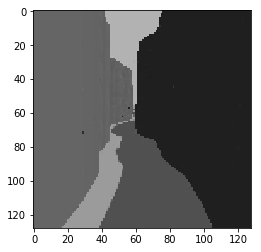

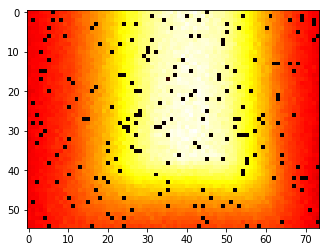

right min: 0.357712417841, avg: 3.47164583206


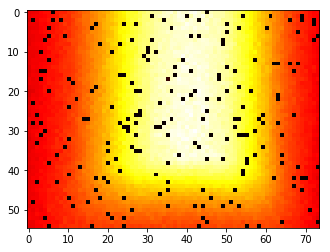

straight min: 0.360431849957, avg: 3.46398019791


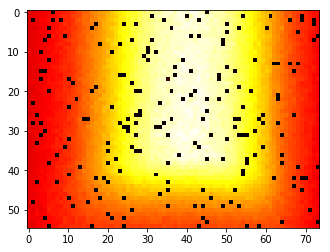

left min: 0.361778527498, avg: 3.45804715157
right


In [131]:
# Test on training data
data_type='test'
control_map={-1:'right',0:'straight',1:'left'}
# correct=0
# total=0
for index, ok, batch in data.generate_batch(data_type):
#     for b in batch:
        if batch[0]['ctr'] == -1: label = 'right'
        elif batch[0]['ctr'] == 1: label = 'left'
        else: label = 'straight'
        
#         plt.imshow(batch[0]['depth'], cmap='hot')
#         plt.show()
        plt.imshow(batch[0]['img']*255)
        plt.show()
        
        # right
        result, losses, aux_res = model.forward([batch[0]['img']], actions=[[1]])
        plt.imshow(result[0], cmap='hot')
        plt.show()
        print("{0} min: {1}, avg: {2}".format('right', np.amin(result[0][result[0]!=0]), np.mean(result[0][result[0]!=0])))
        # straight
        result, losses, aux_res = model.forward([batch[0]['img']], actions=[[0]])
        plt.imshow(result[0], cmap='hot')
        plt.show()
        print("{0} min: {1}, avg: {2}".format('straight', np.amin(result[0][result[0]!=0]), np.mean(result[0][result[0]!=0])))
        # left
        result, losses, aux_res = model.forward([batch[0]['img']], actions=[[-1]])
        plt.imshow(result[0], cmap='hot')
        plt.show()
        print("{0} min: {1}, avg: {2}".format('left', np.amin(result[0][result[0]!=0]), np.mean(result[0][result[0]!=0])))
        
        
        print("{0}".format(label))
        break
#         total +=1
#         if batch[0]['ctr']==np.argmax(q_values)-1: correct += 1


left
left: 525.549019608 right: 488.941176471
(14, 19)
(128, 128, 3)


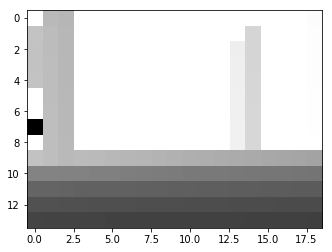

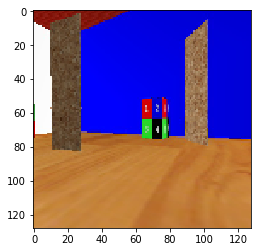

14.0
19.0


In [8]:
data_type='train'
for index, ok, batch in data.generate_batch(data_type):
    de=batch[0]['depth'][::4,::4]
    de[de==0]=5
    im=batch[0]['img']*255
#     im=im[::4,::4,:]
    de_pruned_left=de[:,0:10]
    de_pruned_left[de_pruned_left==0]=5
    de_pruned_right=de[:,10:]
    de_pruned_right[de_pruned_right==0]=5
    print("right" if sum(sum(de_pruned_left))<sum(sum(de_pruned_right)) else "left" )
    print("left: {0} right: {1}".format(sum(sum(de_pruned_left)),sum(sum(de_pruned_right))))
    print de.shape
    print im.shape
    plt.imshow(de, cmap='gray')
    plt.show()
    plt.imshow(im)
    plt.show()
    break
print str(np.ceil(55/4.))
print str(np.ceil(74/4.))


In [9]:
messages=[]
res=[]
for _ in range(20):
    # Test on almost collision dataset: 44% accuracy 
    # mean:44.034591195, var:0.914629563704, min:41.7610062893, max:45.7232704403
    # Pick right action according to summing over different regions
    data_type='test'
    correct=0
    total=0
    for index, ok, batch in data.generate_batch(data_type):
        actions=[[b['ctr']] for b in batch]
        result, losses, aux_res = model.forward([b['img'] for b in batch], actions=actions)   
        for i, r in enumerate(result):
    #         plt.imshow(batch[0]['img']*255)
    #         plt.show()        
    #         plt.imshow(r)
    #         plt.show()
    #         parts=[r[:,int(r.shape[1]*2/3):],
    #                r[:,int(r.shape[1]/3):int(2*r.shape[1]/3)],
    #                r[:,0:int(r.shape[1]/3)]]
            parts=[r[:,20:],
                   r[:,int(r.shape[1]/2-10):int(r.shape[1]/2+10)],
                   r[:,0:20]]

            q_values=[sum(sum(p)) for p in parts]
            total +=1
    #         print "q_values {0} \n pred: {1} \n correct action {2} \n --> {3}".format(q_values, np.argmax(q_values)-1, actions[i], 'correct' if actions[i]==np.argmax(q_values)-1 else 'wrong')

            if actions[i]==np.argmax(q_values)-1: 
                correct += 1
    #         break
    #     break
    res.append(100*correct/float(total))
    messages.append("{0}/{1}={2:.02f}".format(correct, total, 100*correct/float(total)))

for m in messages: print m

print("mean:{0}, var:{1}, min:{2}, max:{3}".format(np.mean(res), np.var(res), min(res), max(res)))
    

batch 10 of 144
batch 20 of 144
batch 30 of 144
batch 40 of 144
batch 50 of 144
batch 60 of 144
batch 70 of 144
batch 80 of 144
batch 90 of 144
batch 100 of 144
batch 110 of 144
batch 120 of 144
batch 130 of 144
batch 140 of 144
batch 10 of 144
batch 20 of 144
batch 30 of 144
batch 40 of 144
batch 50 of 144
batch 60 of 144
batch 70 of 144
batch 80 of 144
batch 90 of 144
batch 100 of 144
batch 110 of 144
batch 120 of 144
batch 130 of 144
batch 140 of 144
batch 10 of 144
batch 20 of 144
batch 30 of 144
batch 40 of 144
batch 50 of 144
batch 60 of 144
batch 70 of 144
batch 80 of 144
batch 90 of 144
batch 100 of 144
batch 110 of 144
batch 120 of 144
batch 130 of 144
batch 140 of 144
batch 10 of 144
batch 20 of 144
batch 30 of 144
batch 40 of 144
batch 50 of 144
batch 60 of 144
batch 70 of 144
batch 80 of 144
batch 90 of 144
batch 100 of 144
batch 110 of 144
batch 120 of 144
batch 130 of 144
batch 140 of 144
batch 10 of 144
batch 20 of 144
batch 30 of 144
batch 40 of 144
batch 50 of 144
batc

In [157]:
res=[]
messages=[]
for _ in range(20):
    # Test on almost collision dataset: mean:57.7830188679, var:1.15338594201, min:55.7232704403, max:59.1823899371
    data_type='test'
    correct=0
    total=0
    for index, ok, batch in data.generate_batch(data_type):
        # plt.imshow(batch[0]['img']*255)
        # plt.show() 
        q_values=[]
        result, losses, aux_res = model.forward([b['img'] for b in batch], actions=[[-1] for b in batch])
        # plt.imshow(result[0])
        # plt.show()

        q_values.append([sum(r[r!=0]) for r in result])
        result, losses, aux_res = model.forward([b['img'] for b in batch], actions=[[0] for b in batch])
        # plt.imshow(result[0])
        # plt.show()

        q_values.append([sum(r[r!=0]) for r in result])
        result, losses, aux_res = model.forward([b['img'] for b in batch], actions=[[1] for b in batch])
        # plt.imshow(result[0])
        # plt.show()

        q_values.append([sum(r[r!=0]) for r in result])
        
#         print q_values
        
        for i in range(len(batch)):
            total+=1
            qs=[q_values[0][i], q_values[1][i], q_values[2][i]]
            if batch[i]['ctr']==np.argmax(qs)-1: correct +=1
#             print "GT: {0} Q-ES: {1} --> {2}".format(batch[i]['ctr'], np.argmax(qs)-1, 'correct' if batch[i]['ctr']==np.argmax(qs)-1 else 'wrong')
#             break
#         break
#     break
    res.append(100*correct/float(total))
    messages.append("{0}/{1}={2:.02f}".format(correct, total, 100*correct/float(total)))


for m in messages: print m

print("mean:{0}, var:{1}, min:{2}, max:{3}".format(np.mean(res), np.var(res), min(res), max(res)))


batch 10 of 159
batch 20 of 159
batch 30 of 159
batch 40 of 159
batch 50 of 159
batch 60 of 159
batch 70 of 159
batch 80 of 159
batch 90 of 159
batch 100 of 159
batch 110 of 159
batch 120 of 159
batch 130 of 159
batch 140 of 159
batch 150 of 159
batch 10 of 159
batch 20 of 159
batch 30 of 159
batch 40 of 159
batch 50 of 159
batch 60 of 159
batch 70 of 159
batch 80 of 159
batch 90 of 159
batch 100 of 159
batch 110 of 159
batch 120 of 159
batch 130 of 159
batch 140 of 159
batch 150 of 159
batch 10 of 159
batch 20 of 159
batch 30 of 159
batch 40 of 159
batch 50 of 159
batch 60 of 159
batch 70 of 159
batch 80 of 159
batch 90 of 159
batch 100 of 159
batch 110 of 159
batch 120 of 159
batch 130 of 159
batch 140 of 159
batch 150 of 159
batch 10 of 159
batch 20 of 159
batch 30 of 159
batch 40 of 159
batch 50 of 159
batch 60 of 159
batch 70 of 159
batch 80 of 159
batch 90 of 159
batch 100 of 159
batch 110 of 159
batch 120 of 159
batch 130 of 159
batch 140 of 159
batch 150 of 159
batch 10 of 159


In [ ]:
# Test on almost collision dataset: 59.3% accuracy
data_type='test'
correct=0
total=0
for index, ok, batch in data.generate_batch(data_type):
    for b in batch:
        result, losses, aux_res = model.forward([batch[0]['img']], actions=[[0]])   
        total +=1
        if batch[0]['ctr']==np.argmax(q_values)-1: correct += 1
        
print("{0}/{1}".format(correct, total))

(128, 128, 3)
0.0674614
1.97798
0.893229
GT: 1.0 Q-ES: 1 --> correct


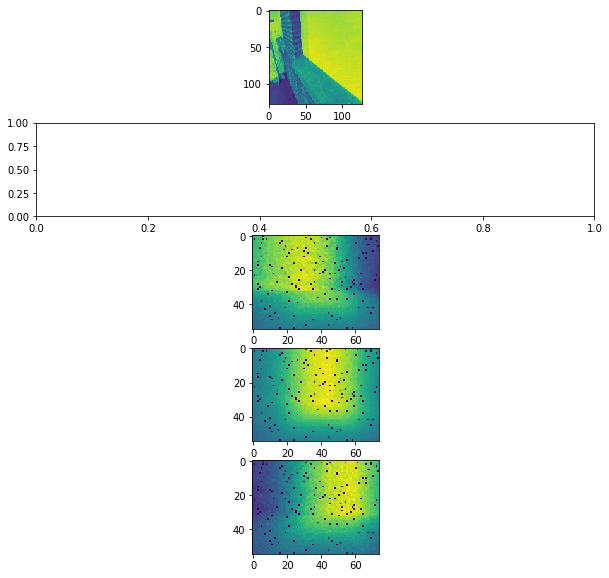

In [21]:
# Load a batch and display results
data_type='test'
f, ax = plt.subplots(5, figsize=(10,10))
for index, ok, batch in data.generate_batch(data_type):
#     ax[0].imshow(cv2.cvtColor(batch[0]['img'], cv2.COLOR_BGR2RGB))
    print batch[0]['img'].shape
    ax[0].imshow(batch[0]['img'][:,:,0])
#     ax[1].imshow(batch[0]['depth'])
    q_values=[]
    result, losses, aux_res = model.forward([batch[0]['img']], actions=[[10]])
    ax[2].imshow(result[0])
    print min(result[result!=0])
    
    q_values.append(sum(result[result!=0]))
    
    result, losses, aux_res = model.forward([batch[0]['img']], actions=[[0]])
    ax[3].imshow(result[0])
    q_values.append(sum(result[result!=0]))
    print min(result[result!=0])
    
    result, losses, aux_res = model.forward([batch[0]['img']], actions=[[-10]])
    q_values.append(sum(result[result!=0]))
    ax[4].imshow(result[0])
    print min(result[result!=0])

    print "GT: {0} Q-ES: {1} --> {2}".format(batch[0]['ctr'], np.argmax(q_values)-1, 'correct' if batch[0]['ctr']==np.argmax(q_values)-1 else 'wrong')

    break
plt.show()

In [39]:
sum(result[result!=0])

11443.861469984055

15520.3
[[[ 1.7027353   1.84683192  1.54338682 ...,  3.22902703  2.83582377
    3.25331044]
  [ 1.27274919  1.66538739  1.75851655 ...,  3.19417214  2.95188355
    2.88876462]
  [ 1.44272661  0.          1.53400648 ...,  3.05596113  0.          2.72797632]
  ..., 
  [ 1.67741632  1.77398622  2.03700972 ...,  3.12999654  2.54793453
    2.86266398]
  [ 1.56576312  1.72361612  1.63785088 ...,  2.59515762  2.44938612
    2.17755342]
  [ 1.53277397  1.93963885  1.97166252 ...,  2.59505439  2.65330052
    2.47972107]]]
0.0
6.77764
[ 1.7027353   1.27274919  1.44272661  1.54756129  1.88309932  1.43664896
  1.4237982   1.468207    1.54281318  1.75914228  1.56434798  1.57064354
  1.49594617  1.17343175  1.19828868  1.46316707  1.59848833  1.56007528
  1.41106355  1.56924593  1.51775789  1.49435651  1.61216962  1.32934129
  1.62170362  1.35692096  1.3853792   1.60260367  1.54901147  1.71834338
  1.41425872  1.44391429  1.67392206  1.09754646  1.5646888   1.83676982
  1.55366516  1.67060673  1.743